<a href="https://colab.research.google.com/github/faseenafarz/machine-learning/blob/main/lung_disease_classification_using_respiratory_sounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tensorflow.keras import layers,models

In [ ]:
import sys
with open('requirements.txt', 'w') as f:
  f.write(f'tensorflow=={tf.__version__}\n')
  f.write(f'numpy=={np.__version__}\n')
  f.write(f'keras=={keras.__version__}\n')
  f.write(f'librosa=={librosa.__version__}\n')
  f.write(f'python=={sys.version}\n')
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def Extract_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [ ]:
patient_info=pd.read_csv(r"/content/drive/MyDrive/lung_disease/demographic_info.txt", names=['Patient ID','Age','Sex','Adult BMI','Child Weight(kgs)','Child height(cms)'],delimiter=" ")
patient_diagnosis=pd.read_csv(r"/content/drive/MyDrive/lung_disease/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",
                              names=['Patient ID','Diagnosis'])
patient_record=patient_info.join(patient_diagnosis.set_index('Patient ID'),on='Patient ID',how='left')

In [ ]:
# Set the root directory for the files
root = r"/content/drive/MyDrive/lung_disease/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files"

# Extract filenames without extensions for all .txt files in the directory
filenames = [i.split('.')[0] for i in os.listdir(path=root) if '.txt' in i]

# Initialize lists and dictionary
a_list = []  # List for storing patient details
rec_annotations = []  # List for storing audio data
rec_annotations_dict = {}  # Dictionary to map patient details to audio data

# Iterate through each file and extract data
for i in filenames:
    (a, b) = Extract_Data(i, root)
    a_list.append(a)  # Append patient details
    rec_annotations.append(b)  # Append audio data
    rec_annotations_dict[i] = b  # Add to dictionary

# Combine patient details into a single DataFrame
recording_info = pd.concat(a_list, axis=0)


In [ ]:
# Initialize lists for storing counts and filenames
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []

# Iterate through each filename and process the corresponding data
for c in filenames:
    d = rec_annotations_dict[c]  # Get the data for the current file

    # Count the occurrences of each condition
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)

    # Append the counts to the respective lists
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(c)  # Append the filename to the list

# Create a DataFrame with the filenames
file_label_df = pd.DataFrame(data={'filename': filename_list})
file_label_df.head()


,filename
0,160_1b3_Ar_mc_AKGC417L
1,160_1b4_Al_mc_AKGC417L
2,160_1b3_Lr_mc_AKGC417L
3,160_1b3_Al_mc_AKGC417L
4,160_1b3_Tc_mc_AKGC417L


In [ ]:
# Define the path to the audio files
audio = r"/content/drive/MyDrive/lung_disease/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files"

# Initialize lists to store extracted information
diagnosis = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []

# Iterate through each filename in the DataFrame
for i in tqdm(range(len(file_label_df['filename']))):
    # Split the filename to extract patient details
    info = file_label_df['filename'][i].split('_')
    patient_id, recording_idx, chest_loc, acq_mode, equipment = info

    # Append extracted details to respective lists
    diagnosis.append(patient_record['Diagnosis'][int(patient_id) - 101])
    patient_number.append(patient_id)
    recording_index.append(recording_idx)
    chest_location.append(chest_loc)
    acquisition_mode.append(acq_mode)
    recording_equipment.append(equipment)

# Add the extracted details to the DataFrame
file_label_df['Diagnosis'] = diagnosis
file_label_df['Patient Number'] = patient_number
file_label_df['Chest Location'] = chest_location
file_label_df['Acquisition Mode'] = acquisition_mode
file_label_df['Recording Equipment'] = recording_equipment

# Display the count of each diagnosis
file_label_df['Diagnosis'].value_counts()


  0%|          | 0/920 [00:00<?, ?it/s]

,count
Diagnosis,
COPD,793
Pneumonia,37
Healthy,35
URTI,23
Bronchiectasis,16
Bronchiolitis,13
LRTI,2
Asthma,1


In [ ]:
file_label_df.head()

,filename,Diagnosis,Patient Number,Chest Location,Acquisition Mode,Recording Equipment
0,160_1b3_Ar_mc_AKGC417L,COPD,160,Ar,mc,AKGC417L
1,160_1b4_Al_mc_AKGC417L,COPD,160,Al,mc,AKGC417L
2,160_1b3_Lr_mc_AKGC417L,COPD,160,Lr,mc,AKGC417L
3,160_1b3_Al_mc_AKGC417L,COPD,160,Al,mc,AKGC417L
4,160_1b3_Tc_mc_AKGC417L,COPD,160,Tc,mc,AKGC417L


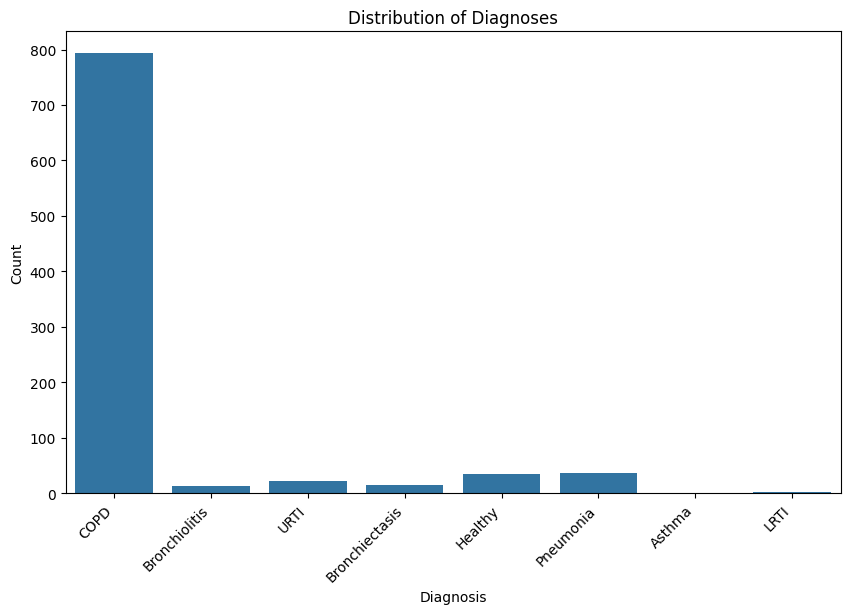

In [ ]:
# Plotting the diagnosis distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Diagnosis', data=file_label_df)
plt.title('Distribution of Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

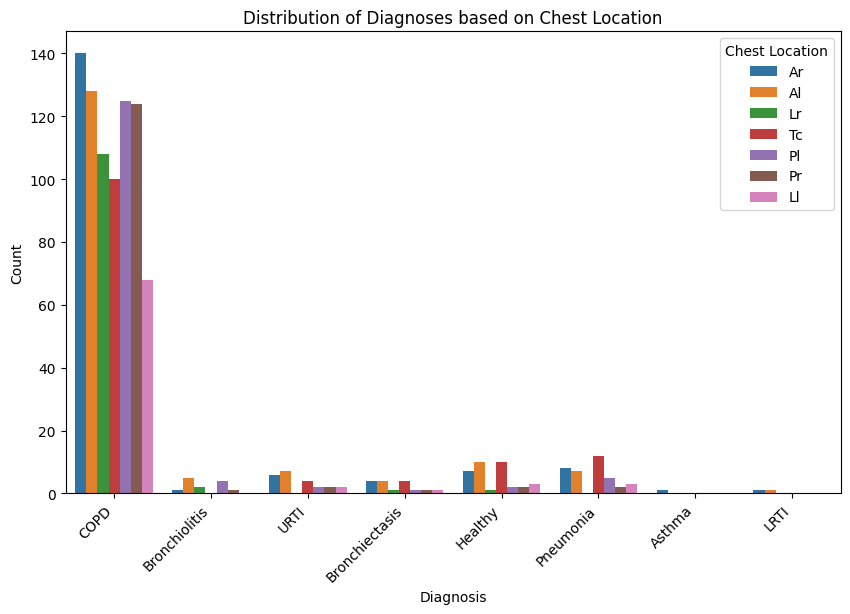

In [ ]:
# Plotting the diagnosis distribution based on chest location
plt.figure(figsize=(10, 6))
sns.countplot(x='Diagnosis', hue='Chest Location', data=file_label_df)
plt.title('Distribution of Diagnoses based on Chest Location')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


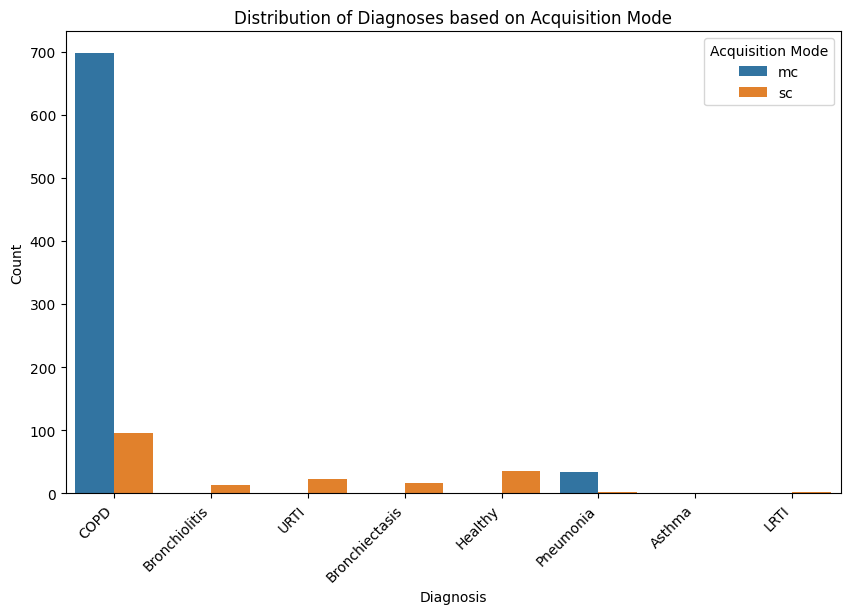

In [ ]:
# Plotting the diagnosis distribution based on acquisition mode
plt.figure(figsize=(10, 6))
sns.countplot(x='Diagnosis', hue='Acquisition Mode', data=file_label_df)
plt.title('Distribution of Diagnoses based on Acquisition Mode')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

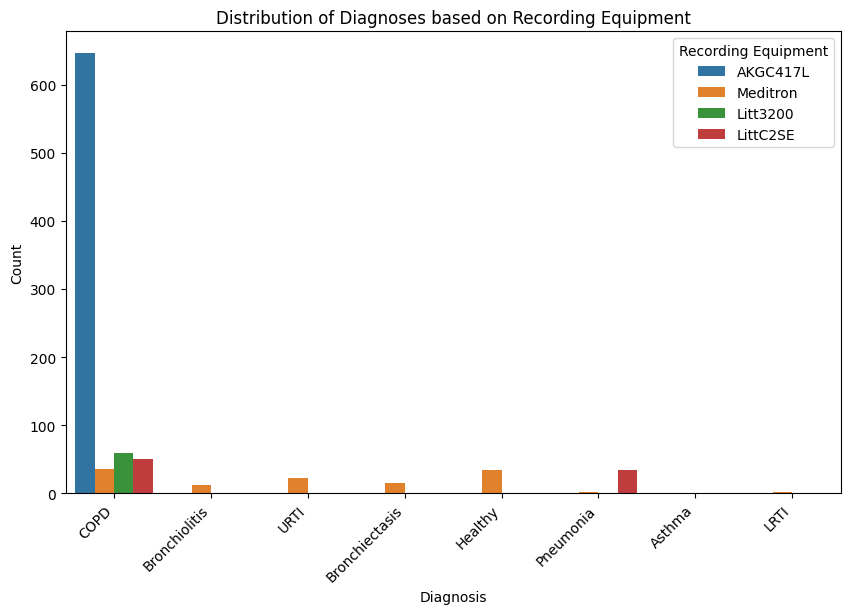

In [ ]:
# Plotting the diagnosis distribution based on recording equipment
plt.figure(figsize=(10, 6))
sns.countplot(x='Diagnosis', hue='Recording Equipment', data=file_label_df)
plt.title('Distribution of Diagnoses based on Recording Equipment')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
def preprocessing(audio_file, mode):
    # Resample audio to 16 kHz
    sr_new = 16000  # 16 kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)

    # Pad or truncate audio to 5 seconds
    max_len = 5 * sr_new  # 5 seconds worth of samples at 16 kHz
    if x.shape[0] < max_len:
        # Pad with zeros if shorter than 5 seconds
        pad_width = max_len - x.shape[0]
        x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
        # Truncate if longer than 5 seconds
        x = x[:max_len]

    # Extract features based on the mode
    if mode == 'mfcc':
        feature = librosa.feature.mfcc(y=x, sr=sr_new)
    elif mode == 'log_mel':
        feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
        feature = librosa.power_to_db(feature, ref=np.max)

    return feature


In [ ]:
def preprocessing(audio_file, mode):
    #resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)

    # padding sound
    max_len = 5 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]

    if mode == 'mfcc':
      feature = librosa.feature.mfcc(y=x, sr=sr_new)

    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)


    return feature

In [ ]:
labels = []
preprocessed_data = []
for i in tqdm(range(len(file_label_df['filename']))):
  labels.append(file_label_df['Diagnosis'][i])
  audio_file = audio +"/"+file_label_df['filename'][i] + '.wav'
  data = preprocessing(audio_file,mode='mfcc')
  preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)


  0%|          | 0/920 [00:00<?, ?it/s]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
print(preprocessed_data.shape)

(920, 20, 157)


In [ ]:
preprocessed_data = preprocessed_data.reshape((-1, 20, 157, 1))
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels,num_classes=8)
oh_labels
type(oh_labels)
print(list(encoder.classes_))

['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']


In [ ]:
unique_values, counts = np.unique(oh_labels, return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.0, Count: 6440
Value: 1.0, Count: 920


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, oh_labels,
                                                    test_size=0.2, random_state = 42)

In [ ]:
num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 19, 156, 16)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 9, 78, 64)           │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 77, 32)           │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4, 38, 64)           │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 37, 64)           │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,472 (111.22 KB)

 Trainable params: 28,472 (111.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
y_train[1].shape
num_epochs = 40
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()
history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.4689 - loss: 8.3404
Epoch 1: val_accuracy improved from -inf to 0.71622, saving model to mymodel2_01.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - accuracy: 0.4850 - loss: 8.0238 - val_accuracy: 0.7162 - val_loss: 2.8857
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7892 - loss: 1.8054
Epoch 2: val_accuracy improved from 0.71622 to 0.77027, saving model to mymodel2_02.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.7905 - loss: 1.7923 - val_accuracy: 0.7703 - val_loss: 2.3872
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7877 - loss: 1.3102
Epoch 3: val_accuracy improved from 0.77027 to 0.87838, saving model to mymodel2_03.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.7906 - loss: 1.3061 - val_accuracy: 0.8784 - val_loss: 1.4465
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8316 - loss: 1.0265
Epoch 4: val_accuracy did not improve 

In [ ]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.875
Testing Accuracy:  0.8586956262588501


In [ ]:
preds = model.predict(x_test) # label scores
classpreds = np.argmax(preds, axis=1) # predicted classes
y_testclass = np.argmax(y_test, axis=1) # true classes

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [ ]:
print(confusion_matrix(y_testclass, classpreds))

[[  0   0   1   0   0   0]
 [  0   0   1   0   0   0]
 [  0   0 153   2   6   0]
 [  0   0   2   2   2   0]
 [  0   0   7   0   2   0]
 [  1   1   3   0   0   1]]


Data balancing

Training after oversampling the data

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

n_samples, height, width, channels = preprocessed_data.shape
X_reshaped = preprocessed_data.reshape(n_samples, -1)

# Instantiate RandomOverSampler
random_oversampler = RandomOverSampler(random_state=42)

# Upsample the minority class using RandomOverSampler
X_resampled, y_resampled = random_oversampler.fit_resample(X_reshaped, oh_labels)
X_restored = X_resampled.reshape(-1, 20, 157, 1)

# Check the shape of the resampled data
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

Shape of X_resampled: (6344, 3140)
Shape of y_resampled: (6344, 8)


In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_restored, y_resampled, stratify=y_resampled,
                                                    test_size=0.2, random_state = 42)

In [ ]:
num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns,num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))


# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# train model
num_epochs = 30
num_batch_size = 64
callbacks = [
    ModelCheckpoint(
        filepath='mymodel3_{epoch:02d}.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train1, y_train1, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.1535 - loss: 6.0263
Epoch 1: val_accuracy improved from -inf to 0.21654, saving model to mymodel3_01.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - accuracy: 0.1540 - loss: 5.9893 - val_accuracy: 0.2165 - val_loss: 1.8919
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.3339 - loss: 1.7723
Epoch 2: val_accuracy improved from 0.21654 to 0.51181, saving model to mymodel3_02.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.3344 - loss: 1.7712 - val_accuracy: 0.5118 - val_loss: 1.6022
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.4509 - loss: 1.5180
Epoch 3: val_accuracy did not improve from 0.51181
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.4513 - loss: 1.5172 - val_accuracy: 0.4823 - val_loss: 1.4146
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5553 - loss: 1.3013
Epoch 4: val_accuracy improved from 0.51181 to 0.57677, saving model to my

In [ ]:
#save this model in drive

!cp mymodel3_26.keras /content/drive/MyDrive/

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train1, y_train1,
                       verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test1, y_test1, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9834482669830322
Testing Accuracy:  0.9763593673706055


In [ ]:
preds = model.predict(x_test1) # label scores

classpreds = np.argmax(preds, axis=1) # predicted classes

y_testclass = np.argmax(y_test1, axis=1) # true classes

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [ ]:
print(confusion_matrix(y_testclass, classpreds))

[[159   0   0   0   0   0   0   0]
 [  0 159   0   0   0   0   0   0]
 [  0   0 158   0   0   0   0   0]
 [  0   1   2 143   2   0   9   2]
 [  0   0   3   0 145   7   0   4]
 [  0   0   0   0   0 159   0   0]
 [  0   0   0   0   0   0 158   0]
 [  0   0   0   0   0   0   0 158]]


In [ ]:
# Classification Report
print(classification_report(y_testclass, classpreds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       159
           1       0.99      1.00      1.00       159
           2       0.97      1.00      0.98       158
           3       1.00      0.90      0.95       159
           4       0.99      0.91      0.95       159
           5       0.96      1.00      0.98       159
           6       0.95      1.00      0.97       158
           7       0.96      1.00      0.98       158

    accuracy                           0.98      1269
   macro avg       0.98      0.98      0.98      1269
weighted avg       0.98      0.98      0.98      1269



In [ ]:
encoder.classes_

array(['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI'], dtype='<U14')

In [ ]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('/content/drive/MyDrive/mymodel3_26.keras')

def preprocessing(audio_file, mode):
    #resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)
    max_len = 5 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]

    if mode == 'mfcc':
      feature = librosa.feature.mfcc(y=x, sr=sr_new)

    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)


    return feature

# Example usage:
audio_file = '/content/drive/MyDrive/lung_disease/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav'

processed_audio = preprocessing(audio_file, mode='mfcc')

# Reshape the processed audio to match the model's expected input shape
processed_audio = np.expand_dims(processed_audio, axis=-1)  # Add channel dimension
processed_audio = np.expand_dims(processed_audio, axis=0)   # Add batch dimension

# Make a prediction
prediction = model.predict(processed_audio)

# Get the predicted class
predicted_class = np.argmax(prediction)
# Get the class name corresponding to the predicted class
predicted_class_name = encoder.classes_[predicted_class]

print(f"Predicted Class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicted Class: URTI


In [ ]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('/content/drive/MyDrive/mymodel3_26.keras')

def preprocessing(audio_file, mode):
    #resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)
    max_len = 5 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]

    if mode == 'mfcc':
      feature = librosa.feature.mfcc(y=x, sr=sr_new)

    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)


    return feature

# Example usage:
audio_file = '/content/drive/MyDrive/lung_disease/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav'

processed_audio = preprocessing(audio_file, mode='mfcc')

# Reshape the processed audio to match the model's expected input shape
processed_audio = np.expand_dims(processed_audio, axis=-1)  # Add channel dimension
processed_audio = np.expand_dims(processed_audio, axis=0)   # Add batch dimension

# Make a prediction
prediction = model.predict(processed_audio)

# Get the predicted class
predicted_class = np.argmax(prediction)

predicted_class_name = encoder.classes_[predicted_class]

print(f"Predicted Class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Predicted Class: Asthma
